Below is a copy of the original code provided by Dr. Yosef Zlochower.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import chebyshev as cheby
import scipy.linalg

We will solve the BVP
\begin{eqnarray}
  y''(r) + \frac{2}{r} y'(r) = - 4\pi \rho, \quad 0 < r < r_{\rm out}\\
  y'(0) = 0,\\
  r_{\rm out} y'(r_{\rm out}) + y(r_{\rm out}) = 0 
\end{eqnarray}
 
 Here, we will use Chebyshev polynomials to construct y.
 $$ y(r) \approx \sum_{n=0}^{n_{\rm max}} c_n T_n(x(r)), $$
 where $$x(r) = -1 + 2\left(  \frac{r-0}{r_{\rm max} - 0}\right) $$
 hence $$dx/dr = 2 / r_{\rm max}$$
 
 We'll solve the above equations on Gauss-Lobatto grid with $n_{\rm max} + 1$ points, the first and the last of these being the two end points of the domain.

$$ y'(0) = 0 \to  \sum_{n=0}^{n_{\rm max}} c_n T'_n(-1) dx/dr = 0,$$ 

 $$ r_{\rm out} y'(r_{\rm out}) + y(r_{\rm out}) = 0  \to 
\sum_{n=0}^{n_{\rm max}} c_n \left[r_{\rm out} T'_n(1) dx/dr + T_n(1)\right] = 0$$ 


$$ \sum_{n=0}^{n_{\rm max}} c_n(T''(x_i) (dx/dr)^2 + \frac{2}{r_i} (dx/dr) T'(x_i) ) = - 4 \pi \rho(r_i), \quad i= 1\cdots n_{\rm max} - 1
$$

All of these are equivalent to
$$
{\bf J}{\bf C} = {\bf S},
$$
where ${\bf C} = (c_0, c_1, \cdots)^T$
Hence ${\bf C} = {\bf J}^{-1} {\bf S}$

In [3]:
# Solve Ax = B using generic routines


def SolveLinAlg(A, B):
    """
    Solve the Matric problem Ax = B for x vial LU decomposition
    """
    LU, P = scipy.linalg.lu_factor(A)
    return scipy.linalg.lu_solve((LU, P), B)

In [4]:
def rho(r):
    rho_val = np.where(r<=1, 1-r, 0)
    return rho_val

In [5]:
Rin = 0.0
Rout = 10.0


def x_of_r(r):
    return -1 + 2 * (r - Rin) / (Rout - Rin)


def r_of_x(x):
    return 0.5 * (x + 1) * (Rout - Rin) + Rin


dxdr = 2.0 / (Rout - Rin)

In [6]:
Nmax = 500
grid = cheby.GaussLobattoGrid(Nmax)
r_grid = r_of_x(grid)
J = np.zeros((Nmax + 1, Nmax + 1))

# first  and last rows
# Note the n of Tn is equal to the column number
for col in range(Nmax + 1):
    # r=0 boundary condition
    J[0, col] = dxdr * cheby.ChebyshevTx(col, -1)

    # outer BC
    J[-1, col] = Rout * dxdr * cheby.ChebyshevTx(col, 1) + cheby.ChebyshevT(col, 1)

S = -4 * np.pi * rho(r_grid)  # source term for 'most' of the grid

S[0] = 0  # source terms on the boundaries
S[-1] = 0

# Enforcing solution in the interior points.
for row in range(1, Nmax):
    for col in range(Nmax + 1):
        J[row, col] = (
            dxdr ** 2 * cheby.ChebyshevTxx(col, grid[row])
            + 2.0 / r_grid[row] * dxdr * cheby.ChebyshevTx(col, grid[row])
        )

In [7]:
# obtain spectal coefficients by solving JC = S
C = SolveLinAlg(J, S)

In [8]:
# reconstruct solution on a fine grid

test_grid = np.linspace(Rin + 1.0e-4, Rout - 1.0e-4, 500)
x_grid = x_of_r(test_grid)

solution = [cheby.ReconT(C, x) for x in x_grid]

yp = np.array([cheby.ReconTx(C, x) for x in x_grid]) * dxdr
ypp = np.array([cheby.ReconTxx(C, x) for x in x_grid]) * dxdr ** 2

resid = ypp + 2 / test_grid * yp + 4 * np.pi * rho(test_grid)

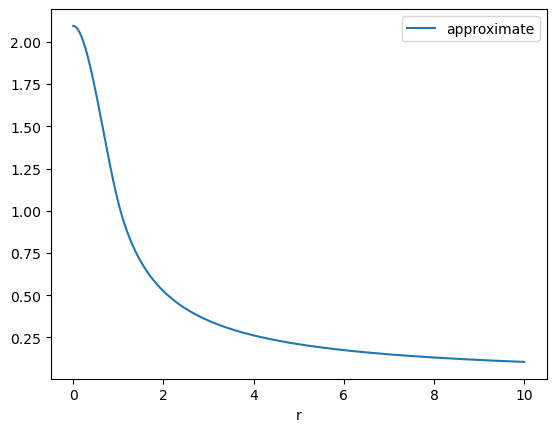

In [9]:
plt.plot(test_grid, solution, label="approximate")
plt.xlabel("r")
plt.legend()

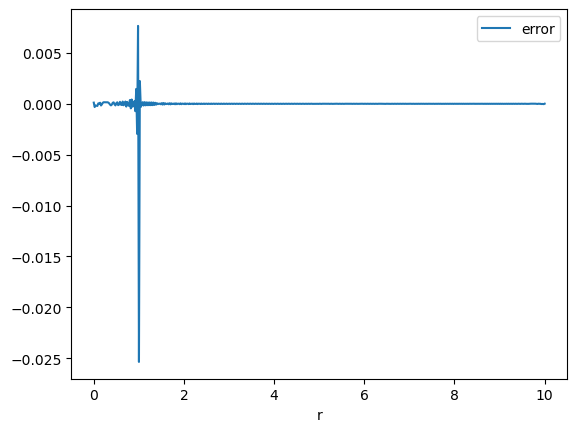

In [10]:
plt.plot(test_grid, resid, label="error")
plt.xlabel("r")
plt.legend()

Here we solve the same problem using two grids that abut each other. We'll refer to these as the `left` and `right` domains. The `left` domain will be $0\leq r \leq r_s$ and the `right` domain will be $r_s\leq r \leq r_{\rm out}$. (we'll take $r_s=1$ and $r_{\rm out}=20$)

On the `left` domain, we have
$$ y_L(r) \approx \sum_{n=0}^{n_{\rm L max}} c_n T_n(x_L(r)) $$
and on the `right` domain we have
$$ y_R(r) \approx \sum_{n=0}^{n_{\rm R max}} d_n T_n(x_R(r)) $$

Here $x_L(r)$ maps $[0,r_s]$ to $[-1,1]$ and
$x_R(r)$ maps $[r_s,r_{\rm out}]$ to $[-1,1]$.

The resulting algebraic equations are:

$$ y'(0) = 0 \to  \sum_{n=0}^{n_{\rm L max}} c_n T'_n(-1) \frac{dx_L}{dr} = 0,$$ 

 $$ r_{\rm out} y'(r_{\rm out}) + y(r_{\rm out}) = 0  \to 
\sum_{n=0}^{n_{\rm R max}} d_n \left[r_{\rm out} T'_n(1) \frac{dx_R}{dr} + T_n(1)\right] = 0$$ 
$$ y_L(r_s) = y_R(r_s) \to  \sum_{n=0}^{n_{\rm L max}} c_n T_n(1) -  \sum_{n=0}^{n_{\rm R max}} d_n T_n(-1) =  0 $$
$$ y_L'(r_s) = y_R'(r_s) \to  \sum_{n=0}^{n_{\rm L max}} c_n \frac{dx_L}{dr} T'_n(1) -  \sum_{n=0}^{n_{\rm R max}} d_n \frac{d x_R}{dr} T'_n(-1) =  0 $$

$$ \sum_{n=0}^{n_{\rm L max}} c_n\left[T_n''(x_i) (\frac{dx_L}{dr})^2 + \frac{2}{r_L(x_i)} (\frac{dx_L}{dr}) T_n'(x_i) \right] = - 4 \pi \rho(r_L(x_i)), \quad i= 1\cdots n_{\rm L max} - 1 $$

$$ \sum_{n=0}^{n_{\rm R max}} d_n\left[T_n''(x_i) (\frac{dx_R}{dr})^2 + \frac{2}{r_R(x_i)} (\frac{dx_R}{dr}) T_n'(x_i) \right] = - 4 \pi \rho(r_R(x_i)), \quad i= 1\cdots n_{\rm R max} - 1 $$

These equations can be written in the form
${\bf J}{\bf C} = {\bf S}$, where ${\bf J}$ is a block diagonal matrix, ${\bf C}$ is the vector $(c_0, c_1,\cdots, c_{nmaxL}, d_0, d_1, \cdots, d_{nmaxR})$

In [11]:
Rin1 = 0.0
Rout1 = 1.0
Rin2 = 1.0
Rout2 = 10.0


def x_of_r1(r):
    return -1 + 2 * (r - Rin1) / (Rout1 - Rin1)


def r_of_x1(x):
    return 0.5 * (x + 1) * (Rout1 - Rin1) + Rin1


dxdr1 = 2.0 / (Rout1 - Rin1)


def x_of_r2(r):
    return -1 + 2 * (r - Rin2) / (Rout2 - Rin2)


def r_of_x2(x):
    return 0.5 * (x + 1) * (Rout2 - Rin2) + Rin2


dxdr2 = 2.0 / (Rout2 - Rin2)

In [12]:
Nmax1 = 100
Nmax2 = 60
grid1 = cheby.GaussLobattoGrid(Nmax1)
grid2 = cheby.GaussLobattoGrid(Nmax2)
r_grid1 = r_of_x1(grid1)
r_grid2 = r_of_x2(grid2)

Ncollo1 = Nmax1 + 1
Ncollo2 = Nmax2 + 1
Ncollo_tot = Ncollo1 + Ncollo2
J = np.zeros((Ncollo_tot, Ncollo_tot))


# Construction Block Diagonal matrix. All elements not explicitly set are zero

# Full first row and 'half' of the the last row of "region 1" and half of the
# first row of "region 2"
for col in range(Ncollo1):
    # Inner BC
    J[0, col] = dxdr1 * cheby.ChebyshevTx(col, -1)  # First row of region 1

    # Consistency of solution at region interface
    J[Nmax1, col] = cheby.ChebyshevT(col, 1)  # Last "region 1 row"

    # consistency of derivative at region interface
    J[Nmax1 + 1, col] = dxdr1 * cheby.ChebyshevTx(col, 1)  # first "region 2 row"

# Full last row and the second 'half' of the the last row of "region 1" and
# the second half of the  first row of "region 2"
for j in range(Ncollo2):
    col = j + Ncollo1
    # Consistency of solution at region interface
    J[Nmax1, col] = -cheby.ChebyshevT(j, -1)  # last "region 1 row"

    # consistency of derivative at region interface
    J[Nmax1 + 1, col] = -dxdr2 * cheby.ChebyshevTx(j, -1)  # first "region 2 row"

    # outer boundary condition
    J[-1, col] = Rout2 * dxdr2 * cheby.ChebyshevTx(j, 1) + cheby.ChebyshevT(j, 1)

rbig = np.concatenate((r_grid1, r_grid2))
S = -4 * np.pi * rho(rbig)  # source term for 'most' of the grid

S[0] = 0  # source terms on the boundaries
S[-1] = 0

S[Nmax1] = 0  # source term at boundary between grids
S[Nmax1 + 1] = 0  # source term at boundary between grids

# Enforcing solution at interior of region 1. All elements
# belonging to "region 2" are zero
for row in range(1, Ncollo1 - 1):
    for col in range(Ncollo1):
        J[row, col] = (
            dxdr1 ** 2 * cheby.ChebyshevTxx(col, grid1[row])
            + 2.0 / r_grid1[ row ] * dxdr1 * cheby.ChebyshevTx(col, grid1[row])
        )
# Enforcing solution at interior of region 2
# belonging to "region 1" are zero
for i in range(1, Ncollo2 - 1):
    for j in range(Ncollo2):
        row = i + Ncollo1
        col = j + Ncollo1
        J[row, col] = (
            dxdr2 ** 2 * cheby.ChebyshevTxx(j, grid2[i])
            + 2.0 / r_grid2[i] * dxdr2 * cheby.ChebyshevTx(j, grid2[i])
        )

In [13]:
C = SolveLinAlg(J, S)

In [14]:
test_grid1 = np.linspace(Rin1 + 1.0e-4, Rout1 - 1e-4, 500)
x_grid1 = x_of_r1(test_grid1)
test_grid2 = np.linspace(Rin2 + 1e-4, Rout2 - 1e-4, 500)
x_grid2 = x_of_r2(test_grid2)

solution1 = np.array([cheby.ReconT(C[0 : Nmax1 + 1], x) for x in x_grid1])
solution2 = np.array([cheby.ReconT(C[Nmax1 + 1 :], x) for x in x_grid2])
yp1 = np.array([cheby.ReconTx(C[0 : Nmax1 + 1], x) for x in x_grid1]) * dxdr1
yp2 = np.array([cheby.ReconTx(C[Nmax1 + 1 :], x) for x in x_grid2]) * dxdr2
ypp1 = np.array([cheby.ReconTxx(C[0 : Nmax1 + 1], x) for x in x_grid1]) * dxdr1 ** 2
ypp2 = np.array([cheby.ReconTxx(C[Nmax1 + 1 :], x) for x in x_grid2]) * dxdr2 ** 2


solution = np.concatenate((solution1, solution2))
yp = np.concatenate((yp1, yp2))
ypp = np.concatenate((ypp1, ypp2))

grid = np.concatenate((test_grid1, test_grid2))
resid = ypp + 2 / grid * yp + 4 * np.pi * rho(grid)

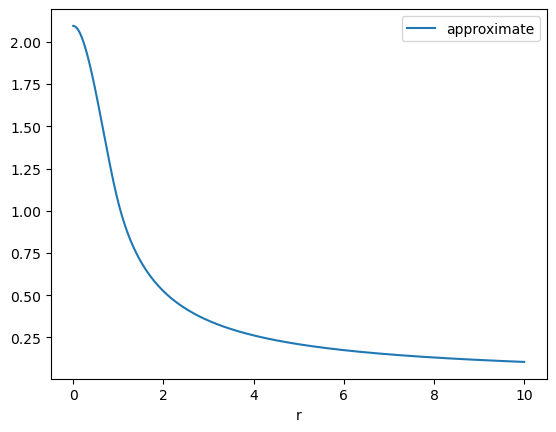

In [15]:
plt.plot(grid, solution, label="approximate")
plt.xlabel("r")
plt.legend()

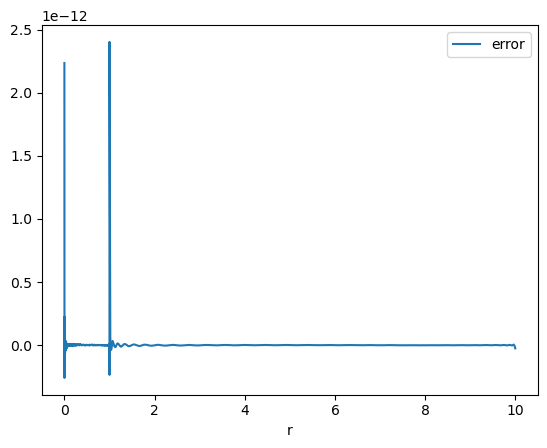

In [16]:
plt.plot(grid, resid, label="error")
plt.xlabel("r")
plt.legend()

----

Now, we are presented with a similar problem. We are solving the following problem: 
\begin{eqnarray}
  \frac{d^2 \psi}{dr^2} + \frac{2}{r} \frac{d \psi}{dr} + 4\pi \rho(r) = 0, \quad 0 < r < r_{\rm max}\\
  \frac{d \psi} {dr} = 0,\\
  r_{\rm max} \frac{d \psi}{dr} + \psi(r_{\rm max}) = 0,\\
  \rho(r) = \left\{\begin{array}{lr} 1 & 0 \leq r \leq 1 \\
                                      e^{-r+1} & r \geq 1 \end{array}\right.
\end{eqnarray}

The first domain we will consider is a single subdomain $[0, r_{\rm max}]$.

Now, we will consider a second domain consisting of two subdomains $[0,1]$ and $[1, r_{\rm max}]$.

In [18]:
# what r_max did we chose? 10

This problem has an analytic solution. *write more about this later